# Model-building phase
- [Data Preprocessing](#Data-Preprocessing)
- [Supervised Models](#Supervised-Models)
    - [Random Forest](#**Random-Forest**)
    - [Gradient Boosting](#**Gradient-Boosting**)
    - [Perceptron](#Perceptron)
    - [SVM](#Support-Vector-Machines-(SVM))


In [1]:
import pandas as pd
import numpy as np
import random
from tools import *
from pprint import pprint
import pickle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from  sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

## Data Preprocessing 

In preprocessing the data we make use of the *prep* function, which simultaneously allows us both to deal with the missing values, giving us the choice of removing them, or partially removing them by replacing the remainder with the mean or median of the corresponding variable, and to scale the data, with the possibility of choosing the method by which to scale such data from all the scalers in scikit-learn, by default the MinMaxScaler is set. The function then takes as input a pandas DataFrame and outputs a numpy ndarray containing the cleaned data from the previous dataset.

Our idea is to generate two datasets: the first by eliminating all observations having at least one component with a missing value, the second by eliminating only 50 percent of those observations. Eventually we will train each model using both datasets and collect their metrics in order to assess whether on average such a reduction in missing values to be eliminated (thus replacing the missing part) resulted in any benefit.

### Scaling Data
To observe if there are difference in performance of the models  trained on a dataset with  all the Nan values imputed and in the models trained on a dataset with only a percentage of Nan values imputed, we have  created 2 dataset:
- one where we imputed all the Nan values (Water 100 dataset)
- one where we imputed only the half Nan values deleting the remain part of observations (Water 50 dataset)

In [2]:
random_seed = 42

In [3]:
# Setting random state for each model
water = pd.read_csv('dataset/drinking_water_potability.csv')
water50 = prep(
    data = water,
    target='Potability',
    axis='obs',
    perc=50,
    fill_method='mean',
    scaler= StandardScaler(),
    random_state = random_seed
)
water100 = prep(
    data = water,
    target='Potability',
    axis='obs',
    perc=0,
    fill_method='mean',
    scaler= StandardScaler(),
    random_state = random_seed
)
print('original dataset size: ', water.shape, '- type: ', type(water))
print('cleaned dataset with 50% of missing values removed: ', np.shape(water50), '- type: ', type(water50))
print('cleaned dataset with no missing values removed: ', np.shape(water100), '- type: ', type(water100))

original dataset size:  (3276, 10) - type:  <class 'pandas.core.frame.DataFrame'>
cleaned dataset with 50% of missing values removed:  (2644, 10) - type:  <class 'numpy.ndarray'>
cleaned dataset with no missing values removed:  (3276, 10) - type:  <class 'numpy.ndarray'>


### Splitting Data
At this point we proceed to divide the dataset into train set, validation set and test set. To do this, we make use of the *train_test_split()* function of scikit-learn.

In [4]:
#Water 50
X_train50, X_val50, X_test50, y_train50, y_val50, y_test50=split(df = water50,
                                                    target_index = 9,
                                                    validation = True,
                                                    perc_train = 0.7,
                                                    random_seed = random_seed,
                                                    verbose=True)

BEFORE SPLITTING: 

X shape:  (2644, 9)
y shape:  (2644,)

AFTER SPLITTING: 
X_train shape:  (1850, 9)
y_train shape:  (1850,)
X_test shape:  (794, 9)
y_test shape:  (794,)
X_val shape:  (397, 9)
y_val shape:  (397,)


In [5]:
#Water 100
X_train100, X_val100, X_test100, y_train100, y_val100, y_test100=split(df = water100,
                                                    target_index = 9,
                                                    perc_train = 0.7,
                                                    random_seed = random_seed,
                                                    verbose=True)

BEFORE SPLITTING: 

X shape:  (3276, 9)
y shape:  (3276,)

AFTER SPLITTING: 
X_train shape:  (2293, 9)
y_train shape:  (2293,)
X_test shape:  (983, 9)
y_test shape:  (983,)
X_val shape:  (491, 9)
y_val shape:  (491,)


## Supervised Models
The Supervised models that we chose are the following:
- **Random Forest**
- **XGBoost**


### **Random Forest**

Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In this part of the report we will train the Random Forest on Water100, that one with all the Nan values imputed.

#### Random Forest Base Model

Confusion matrix: 


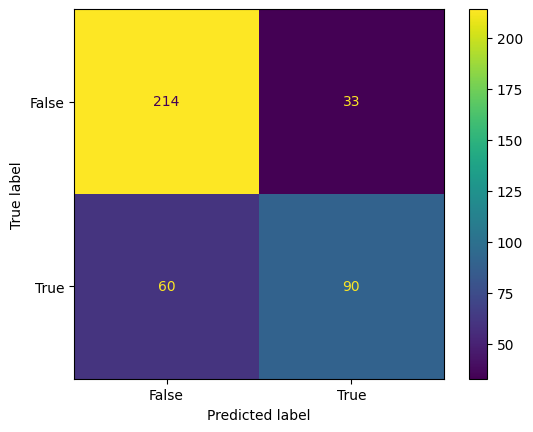

Model Performance: 

accuracy = 76.57%.
recall = 60.00%.
precision = 73.17%.
f1_score = 65.93%.


In [6]:
# Training base model
rf_base_w50 = RandomForestClassifier(random_state = random_seed)
rf_base_w50.fit(X_train50, y_train50)
#Computing the base model accuracy
rf_base_metrics_w50 = evaluate(rf_base_w50, X_val50, y_val50,conf_matrix=True)

#### Random Search with Cross Validation
 First of all we will start searching the best configuration of hyperparameters with a random search choosing among 
 thousand combinations of hyperparameters 100 random combinations, after this first step we will focus more with a grid 
search around the best combinations found with the random search

In [7]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
rf.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


As we can see there are many hyperparameter that we can tune, but for the moment we will focus more only on  the most importants

In [8]:
random_grid = {
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt','log2', None],
    # Maximum number of levels in tree
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    # Minimum number of samples required to split a node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],
    # Method of selecting samples for training each tree
    'bootstrap': [True, False],
    # Metrics  to measure the quality of a split.
    'criterion':['gini', 'entropy', 'log_loss']
}

pprint(random_grid)

rf_random_search_w50 = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid,
    n_iter = 100, 
    cv = 3, 
    random_state=random_seed, 
    n_jobs = -1
    )

#rf_random_search.fit(X_train50, y_train50)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy', 'log_loss'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Actually if we used all the possible combinations we should train the random forest 25920 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

##### Store and Load Models
To avoid  traininig each time the models we will save after every training of the models the results inside *Models folder* using pickle library


In [9]:
#pickle.dump(rf_random_search, open('Models50/Random_Forest_rs_w50.pkl', 'wb'))
rf_random_search_w50=pickle.load(open('Models50/Random_Forest_rs_w50.pkl', 'rb'))

In [10]:
rf_random_search_w50.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'gini',
 'bootstrap': True}

##### Comparing base model with tuned model with Random Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [11]:
# Training tuned model
rf_random_w50 =  RandomForestClassifier(
    bootstrap = True,
    criterion='gini',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=2000,
    random_state=random_seed)

rf_random_w50.fit(X_train50,y_train50)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=2000,
                       random_state=42)

Confusion matrix: 


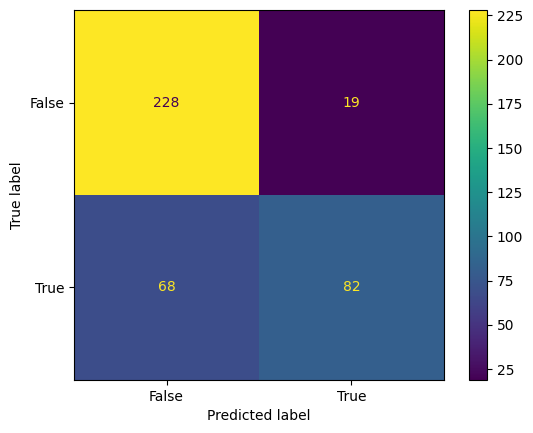

Model Performance: 

accuracy = 78.09%.
recall = 54.67%.
precision = 81.19%.
f1_score = 65.34%.
The tuned model had an improvement of 1.97%. respect the base model


In [12]:
#Computing the tuned model accuracy                                 
rf_random_metrics_w50 = evaluate(rf_random_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model had an improvement of {:0.2f}%. respect the base model'
        .format( 100 * (rf_random_metrics_w50[0] - rf_base_metrics_w50[0]) / rf_base_metrics_w50[0]))


#### Grid Search with Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [13]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)
rf_random_search_w50.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'gini',
 'bootstrap': True}

In [14]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'criterion':['gini'],
    'max_depth': [8,10,12],
    'max_features': ['log2'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1800,1900,2000]
}
# Instantiate the grid search model
rf_grid_search_w50 = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid, 
    cv = 5, n_jobs = -1, 
    verbose = 1)
                         
#rf_grid_search_w50.fit(X_train50, y_train50)

##### Save and load the model

In [15]:
#pickle.dump(rf_grid_search_w50.best_params_, open('Models50/Random_Forest_gs_w50.pkl', 'wb'))
rf_params_best_grid_w50 = pickle.load(open('Models50/Random_Forest_gs_w50.pkl', 'rb'))
rf_params_best_grid_w50

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1800}

##### Comparing base model with tuned model with Grid Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [16]:
# Training tuned model
rf_final_w50 =  RandomForestClassifier(
    bootstrap = True,
    criterion='gini',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=1800,
    random_state=random_seed)

rf_final_w50.fit(X_train50,y_train50)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=3,
                       n_estimators=1800, random_state=42)

Confusion matrix: 


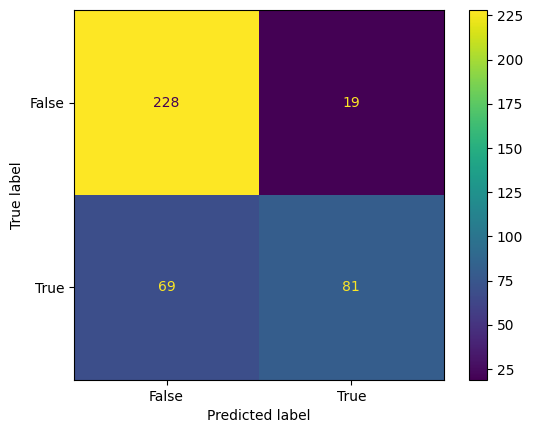

Model Performance: 

accuracy = 77.83%.
recall = 54.00%.
precision = 81.00%.
f1_score = 64.80%.
The tuned model with grid search had an improvement of 1.64%. respect the base model
The tuned model with grid search had an improvement of -0.32%. respect the tuned  model with random search


In [17]:
#Computing the tuned model accuracy                                 
rf_grid_metrics_w50 = evaluate(rf_final_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (rf_grid_metrics_w50[0] - rf_base_metrics_w50[0]) / rf_base_metrics_w50[0]))

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the tuned  model with random search'
                        .format( 100 * (rf_grid_metrics_w50[0] - rf_random_metrics_w50[0]) / rf_random_metrics_w50[0]))

### Gradient Boosting
In this part of the report we will train the Gradient Boosting on Water100, that one with all the Nan values imputed.

In boosting, the individual models are not built on completely random subsets of data and features but sequentially by putting more weight on instances with wrong predictions and high errors. The general idea behind this is that instances, which are hard to predict correctly (“difficult” cases) will be focused on during learning, so that the model learns from past mistakes. When we train each ensemble on a subset of the training set, we also call this Stochastic Gradient Boosting, which can help improve generalizability of our model.The gradient is used to minimize a loss function, similar to how Neural Nets utilize gradient descent to optimize (“learn”) weights. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Confusion matrix: 


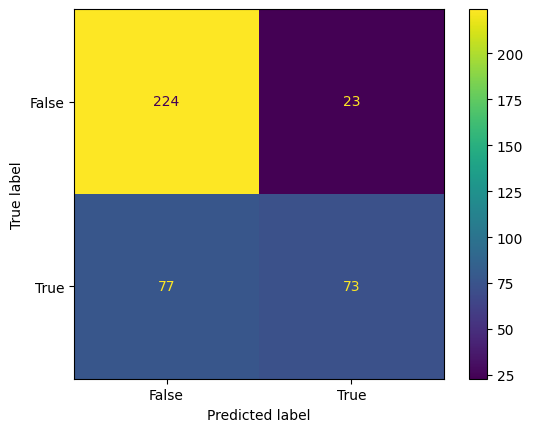

Model Performance: 

accuracy = 74.81%.
recall = 48.67%.
precision = 76.04%.
f1_score = 59.35%.


In [18]:
# Training base model
gb_base_w50 = GradientBoostingClassifier( random_state = random_seed)
gb_base_w50.fit(X_train50, y_train50)
#Computing the base model accuracy
gb_base_metrics_w50= evaluate(gb_base_w50, X_val50, y_val50,conf_matrix=True)

### Random Search with Cross Validation

In [19]:
#Defining Random Forest Claasifier
gb = GradientBoostingClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gb.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [20]:
# Create the random grid
params_grid = {# The loss function to be optimized.
               'loss': ['log_loss','exponential'],
               # Learning rate shrinks the contribution of each tree by learning_rate
               'learning_rate':[0.001,0.01,0.1],
               # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]+[None],
               # Number of features to consider at every split
               'max_features': ['auto', 'sqrt','log2',None],
               # Maximum number of levels in tree
               'max_depth':  [int(x) for x in np.linspace(10, 110, num = 11)]+[None],
               # Minimum number of samples required to split a node
               'min_samples_split': [2, 5, 10],
               # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 2, 4],
               # Metrics  to measure the quality of a split.
               'criterion':['friedman_mse','squared_error']}
pprint(params_grid)

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
gb_random_search_w50 = RandomizedSearchCV(
    estimator = gb, 
    param_distributions = params_grid,
    n_iter = 100, cv = 3, 
    verbose=3, 
    random_state=random_seed, 
    n_jobs = -1)

#gb_random_search_w50.fit(X_train50, y_train50)

{'criterion': ['friedman_mse', 'squared_error'],
 'learning_rate': [0.001, 0.01, 0.1],
 'loss': ['log_loss', 'exponential'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, None]}


Actually if we used all the possible combinations we should train the Gradient Boosting 103000 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

#### Store and Load Models
To avoid  traininig each time the models we will save after every training of the models the results inside *Models folder* using pickle library

In [21]:
#Saving
#pickle.dump(gb_random_search_w50.best_params_, open('Models50/Gradient_Boosting_rs_w50.pkl', 'wb'))
#Loading
gb_params_best_random_w50=pickle.load(open('Models50/Gradient_Boosting_rs_w50.pkl', 'rb'))
gb_params_best_random_w50

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

#### Comparing base model with tuned model with Random Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model, comparing the accuracy of both models on validation set

In [22]:
# Training tuned model
gb_random_w50 =  GradientBoostingClassifier(
    loss='exponential',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=1200,
    learning_rate=0.1,
    criterion='friedman_mse',
    random_state=random_seed)

gb_random_w50.fit(X_train50,y_train50)

GradientBoostingClassifier(loss='exponential', max_depth=10,
                           max_features='sqrt', min_samples_leaf=2,
                           n_estimators=1200, random_state=42)

Confusion matrix: 


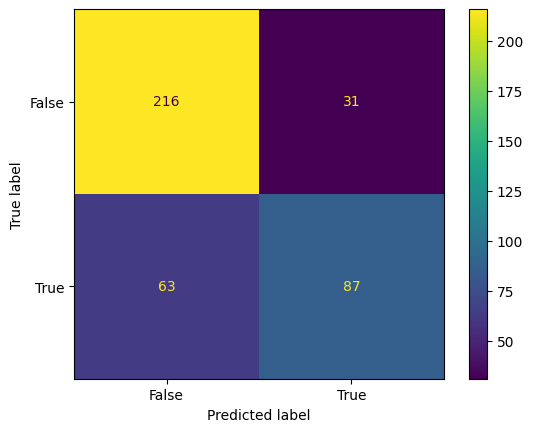

Model Performance: 

accuracy = 76.32%.
recall = 58.00%.
precision = 73.73%.
f1_score = 64.93%.
The tuned model with random search had an improvement of 2.02%. respect the base model


In [23]:
#Computing the tuned model accuracy                                 
gb_random_metrics_w50= evaluate(gb_random_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model with random search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (gb_random_metrics_w50[0] - gb_base_metrics_w50[0]) / gb_base_metrics_w50[0]))

#### Grid Search with Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [24]:
gb_params_best_random_w50

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

In [25]:
# Create the parameter grid based on the results of random search 
params_grid = {
    'loss': ['exponential'],
    'learning_rate': [0.1],
    'criterion':['friedman_mse'],
    'max_depth': [5,10,15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1100,1200,1300]
}
# Instantiate the grid search model
gb_grid_search_w50 = GridSearchCV(
    estimator = gb, 
    param_grid = params_grid, 
    cv = 5, 
    n_jobs = -1, 
    verbose = 3)

#gb_grid_search_w50.fit(X_train50, y_train50)

#### Store and Load Models

In [26]:
#Saving
#pickle.dump(gb_grid_search_w50.best_params_, open('Models50/Gradient_Boosting_gs_w50.pkl', 'wb'))
#Loading
gb_params_best_grid_w50=pickle.load(open('Models50/Gradient_Boosting_gs_w50.pkl', 'rb'))
gb_params_best_grid_w50

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 1100}

#### Comparing tuned models 
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [27]:
# Training tuned model
gb_final_w50 =  GradientBoostingClassifier(
    loss='exponential',
    max_depth=15,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=1100,
    learning_rate=0.1,
    criterion='friedman_mse',
    random_state=random_seed)

gb_final_w50.fit(X_train50,y_train50)

GradientBoostingClassifier(loss='exponential', max_depth=15,
                           max_features='sqrt', min_samples_leaf=3,
                           n_estimators=1100, random_state=42)

Confusion matrix: 


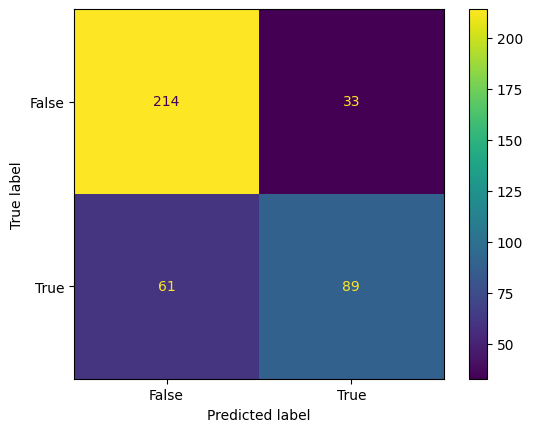

Model Performance: 

accuracy = 76.32%.
recall = 59.33%.
precision = 72.95%.
f1_score = 65.44%.
The tuned model with grid search had an improvement of 2.02%. respect the base model
The tuned model with grid search had an improvement of 0.00%. respect the tuned  model with random search


In [28]:
#Computing the tuned model accuracy                                 
gb_grid_metrics_w50 = evaluate(gb_final_w50, X_val50, y_val50,conf_matrix=True)

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (gb_grid_metrics_w50[0] - gb_base_metrics_w50[0]) / gb_base_metrics_w50[0]))

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the tuned  model with random search'
                        .format( 100 * (gb_grid_metrics_w50[0] - gb_random_metrics_w50[0]) / gb_random_metrics_w50[0]))


### Support Vector Machines (SVM)

In [ ]:
svmodel = SVC(
    random_state= random_seed
)

print('Parameters currently in use:\n')
pprint(svmodel.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [ ]:
svmodel.fit(X = X_train100, y = y_train100)
evaluate(svmodel, X_val100, y_val100)

Model Performance
Accuracy = 68.64%.


0.6863543788187373

#### Grid Search w/ Cross Validation

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf']
    }

svc_final = GridSearchCV(
    estimator = SVC(random_state=random_seed),
    param_distributions = param_grid,
    n_iter = 100,
    cv = 3, 
    verbose = 3, 
    random_state = random_seed, 
    n_jobs = -1
)

svc_final.fit(X_train100, y_train100)

In [ ]:
svc_final.best_params_

NameError: name 'svc_final' is not defined

##### Save and load the model

In [ ]:
#pickle.dump(svc_final, open('Models/svc_final.pkl', 'wb'))
svc_final = pickle.load(open('Models/svc_final.pkl', 'rb'))

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'poly', 'rbf']},
                   random_state=42, verbose=3)

## Evalution Models

| Models              | Test Accuracy | Test Recall | Test Precision | F1 Score |
|---------------------|---------------|-------------|----------------|----------|
| Logistic Regression |               |             |                |          |
| Random Forest       |               |             |                |          |
| K-NN                |               |             |                |          |
| Orazio              |               |             |                |          |